In [2]:
from google.colab import drive
import os
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Change this path to the exact folder where your images are located
INPUT_FOLDER = '/content/drive/MyDrive/I'
OUTPUT_FOLDER_NAME = 'cleaned_dataset3'

def process_images(input_path):
    # Setup full output path
    output_path = os.path.join(input_path, OUTPUT_FOLDER_NAME)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        print(f"Created folder: {output_path}")

    # Exclusions
    skip_suffixes = ("_90.jpeg", "_180.jpeg", "_270.jpeg")

    files = [f for f in os.listdir(input_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    processed_count = 0

    print("Processing...")
    for filename in files:
        # Check if the file should be ignored based on suffix
        if any(filename.lower().endswith(suffix) for suffix in skip_suffixes):
            continue

        img_path = os.path.join(input_path, filename)

        try:
            with Image.open(img_path) as img:
                width, height = img.size

                # Gemini logo is in the bottom right corner.
                # Cropping 70 pixels from the bottom ensures the logo and
                # its slight gradient shadow are completely removed.
                # Box format: (left, top, right, bottom)
                crop_box = (0, 0, width, height - 80)
                cropped_img = img.crop(crop_box)

                # Save to the new subfolder
                cropped_img.save(os.path.join(output_path, filename))
                processed_count += 1
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

    print(f"\n--- Process Complete ---")
    print(f"Total images processed and saved: {processed_count}")
    print(f"Location: {output_path}")

# Run the function
process_images(INPUT_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created folder: /content/drive/MyDrive/Inc_etch/Inc_etch/cleaned_dataset3
Processing...

--- Process Complete ---
Total images processed and saved: 53
Location: /content/drive/MyDrive/Inc_etch/Inc_etch/cleaned_dataset3


In [19]:
from google.colab import drive
import os
from PIL import Image
drive.mount('/content/drive', force_remount=True)


# --- CONFIGURATION ---
# Use the 'cleaned_dataset' path generated from the previous script
SOURCE_FOLDER = '/content/drive/MyDrive/Inc_etch/Inc_etch'

def rotate_dataset(folder_path):
    # Supported rotation angles
    angles = [90, 180, 270]

    # Get only the base images (ignore any already rotated files if you run this twice)
    files = [f for f in os.listdir(folder_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))
             and not any(suffix in f for suffix in ["_90", "_180", "_270"])]

    print(f"Found {len(files)} base images. Generating rotations...")

    count = 0
    for filename in files:
        img_path = os.path.join(folder_path, filename)
        name, ext = os.path.splitext(filename)

        try:
            with Image.open(img_path) as img:
                for angle in angles:
                    # Rotate and save
                    # Using expand=True ensures the whole image is kept if dimensions change
                    # though for square/cropped SEM data, this is straightforward.
                    rotated_img = img.rotate(angle, expand=True)

                    new_filename = f"{name}_{angle}{ext}"
                    rotated_img.save(os.path.join(folder_path, new_filename))
                    count += 1
        except Exception as e:
            print(f"Error rotating {filename}: {e}")

    print(f"\nSuccess! Generated {count} rotated images.")
    print(f"Total images now in folder: {len(os.listdir(folder_path))}")

# Execute
rotate_dataset(SOURCE_FOLDER)

Mounted at /content/drive
Found 53 base images. Generating rotations...

Success! Generated 159 rotated images.
Total images now in folder: 212


In [20]:
import os
import signal
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Inc_etch/Inc_etch'
dest_dir = '/content/drive/MyDrive/dataset/defect/ler_incetch/inc_etch'
target_size = (224, 224)
TIMEOUT_SECONDS = 10

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# --- Timeout Logic ---
class TimeoutException(Exception): pass
def timeout_handler(signum, frame): raise TimeoutException()
signal.signal(signal.SIGALRM, timeout_handler)

# 3. Resume Logic
existing_files = [f for f in os.listdir(dest_dir) if f.startswith('test_normal_')]
existing_indices = []
for f in existing_files:
    try:
        idx = int(f.split('_')[-1].split('.')[0])
        existing_indices.append(idx)
    except: continue

start_index = max(existing_indices) + 1 if existing_indices else 1
print(f"1-Channel Prep: Next index will be {start_index}")

# 4. Processing Loop
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
processed_count = 0
files = sorted(os.listdir(source_dir))

for filename in files:
    if filename.lower().endswith(valid_extensions):
        full_path = os.path.join(source_dir, filename)

        signal.alarm(TIMEOUT_SECONDS)
        try:
            with Image.open(full_path) as img:
                # --- MONOCHROME LOGIC ---
                # 'L' = 8-bit pixels, black and white
                # This ensures exactly 1 channel for your custom MobileNet input
                img_1ch = img.convert('L').resize(target_size, Image.Resampling.LANCZOS)

                new_name = f"test_normal_{str(start_index + processed_count).zfill(5)}.jpg"
                save_path = os.path.join(dest_dir, new_name)

                # Save as JPEG (still works for 1-channel 'L' mode)
                img_1ch.save(save_path, "JPEG", quality=95)

            signal.alarm(0)
            processed_count += 1

            if processed_count % 20 == 0:
                print(f"Processed {processed_count} images (1-Channel)...")

        except TimeoutException:
            print(f"TIMEOUT: Skipped {filename}")
            continue
        except Exception as e:
            signal.alarm(0)
            print(f"ERROR: {filename} -> {e}")
            continue

signal.alarm(0)
print(f"\n--- 1-Channel Processing Complete ---")
print(f"Total new images in destination: {processed_count}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1-Channel Prep: Next index will be 1
Processed 20 images (1-Channel)...
Processed 40 images (1-Channel)...
Processed 60 images (1-Channel)...
Processed 80 images (1-Channel)...
Processed 100 images (1-Channel)...
Processed 120 images (1-Channel)...
Processed 140 images (1-Channel)...
Processed 160 images (1-Channel)...
Processed 180 images (1-Channel)...
Processed 200 images (1-Channel)...

--- 1-Channel Processing Complete ---
Total new images in destination: 212


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 1. Define paths
# Update 'SEM_Dataset_Round2' to your actual folder name in Drive
drive_path = '/content/drive/MyDrive/dataset'
local_path = '/content/sem_data_local2'

# 2. Execute high-speed recursive copy
if not os.path.exists(local_path):
    print("Transferring dataset to local VM storage... this may take a few minutes.")
    !cp -r "$drive_path" "$local_path"
    print("Transfer complete.")
else:
    print("Dataset already exists in local storage.")

Transferring dataset to local VM storage... this may take a few minutes.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import torch.ao.quantization as quantization
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Initialize Device (Fixes your NameError)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define the Quantization-Aware Model
class SEMHierarchicalNetV2_QAT(nn.Module):
    def __init__(self):
        super(SEMHierarchicalNetV2_QAT, self).__init__()
        self.quant = quantization.QuantStub()
        self.dequant = quantization.DeQuantStub()

        base = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        old_conv = base.features[0][0]
        base.features[0][0] = nn.Conv2d(1, old_conv.out_channels,
                                        kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            base.features[0][0].weight[:] = old_conv.weight.sum(dim=1, keepdim=True)

        self.backbone = base.features
        self.avgpool = base.avgpool
        feat_dim = 576

        # 5 Specialized Heads
        self.head1 = self._make_head(feat_dim, 2) # Normal vs Defect
        self.head2 = self._make_head(feat_dim, 3) # Branch: OB(0) vs CC(1) vs LER/IE(2)
        self.head3 = self._make_head(feat_dim, 2) # Leaf: Open vs Bridge
        self.head4 = self._make_head(feat_dim, 2) # Leaf: CMP vs Crack
        self.head5 = self._make_head(feat_dim, 2) # Leaf: LER vs Inc_Etch

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        x = self.quant(x)
        x = self.backbone(x)
        x = self.avgpool(x)
        features = torch.flatten(x, 1)
        features_fp = self.dequant(features)

        return {
            "h1": self.head1(features_fp),
            "h2": self.head2(features_fp),
            "h3": self.head3(features_fp),
            "h4": self.head4(features_fp),
            "h5": self.head5(features_fp)
        }

# Initialize Model
model = SEMHierarchicalNetV2_QAT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Using device: cuda


In [7]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np

# 1. Dataset Class with 5-Head Labeling Logic
class SEMHierarchicalDatasetV2(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for root, dirs, files in os.walk(root_dir):
            folder_name = os.path.basename(root).lower()
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    full_path = os.path.join(root, file)

                    # Labels: [H1, H2, H3, H4, H5]
                    # -1 acts as the mask for the CrossEntropyLoss
                    if folder_name == 'normal':
                        self.labels.append([0, -1, -1, -1, -1])
                    elif folder_name == 'open':
                        self.labels.append([1, 0, 0, -1, -1])
                    elif folder_name == 'bridge':
                        self.labels.append([1, 0, 1, -1, -1])
                    elif folder_name == 'cmp':
                        self.labels.append([1, 1, -1, 0, -1])
                    elif folder_name == 'crack':
                        self.labels.append([1, 1, -1, 1, -1])
                    elif folder_name == 'ler':
                        self.labels.append([1, 2, -1, -1, 0])
                    elif folder_name == 'inc_etch':
                        self.labels.append([1, 2, -1, -1, 1])
                    else:
                        continue # Ignores non-leaf folders

                    self.image_paths.append(full_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Open as Grayscale for monochrome SEM images
        image = Image.open(self.image_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

# 2. Setup Parameters & Transforms
DATA_PATH = '/content/sem_data_local'
SEM_MEAN = [0.3698]
SEM_STD = [0.1413]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=SEM_MEAN, std=SEM_STD)
])

# 3. Partitioning (80% Train, 20% Val)
full_dataset = SEMHierarchicalDatasetV2(DATA_PATH, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_subset, val_subset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# 4. Create Loaders
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)

print(f"Data Loaded: {len(full_dataset)} total images.")
print(f"Training set: {len(train_subset)} | Validation set: {len(val_subset)}")

Data Loaded: 2467 total images.
Training set: 1973 | Validation set: 494


In [8]:
def train_round2(model, train_loader, val_loader, epochs=20):
    print(f"Starting Round 2 Training...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Sum loss across all 5 active branches
            loss = 0
            for i, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, i] != -1
                if mask.any():
                    loss += criterion(outputs[h][mask], labels[:, i][mask])

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation with Multi-Head Metrics
        model.eval()
        head_metrics = {f'h{i+1}': [] for i in range(5)}
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                out = model(images)
                for i, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                    mask = labels[:, i] != -1
                    if mask.any():
                        preds = torch.argmax(out[h][mask], dim=1)
                        head_metrics[h].append(accuracy_score(labels[:, i][mask].cpu(), preds.cpu()))

        # Report
        avg_accs = {h: np.mean(accs) if accs else 0 for h, accs in head_metrics.items()}
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss/len(train_loader):.4f}")
        print(f"  Accuracy -> H1 (Defect): {avg_accs['h1']:.2f} | H2 (Branch): {avg_accs['h2']:.2f}")
        print(f"  Sub-Accuracy -> H3 (OB): {avg_accs['h3']:.2f} | H4 (CC): {avg_accs['h4']:.2f} | H5 (LER/IE): {avg_accs['h5']:.2f}")
        print("-" * 50)

# EXECUTE
train_round2(model, train_loader, val_loader)

Starting Round 2 Training...
Epoch [1/20] Loss: 1.5918
  Accuracy -> H1 (Defect): 0.81 | H2 (Branch): 0.90
  Sub-Accuracy -> H3 (OB): 0.80 | H4 (CC): 0.99 | H5 (LER/IE): 0.93
--------------------------------------------------
Epoch [2/20] Loss: 0.4766
  Accuracy -> H1 (Defect): 0.81 | H2 (Branch): 0.84
  Sub-Accuracy -> H3 (OB): 0.90 | H4 (CC): 1.00 | H5 (LER/IE): 0.98
--------------------------------------------------
Epoch [3/20] Loss: 0.3903
  Accuracy -> H1 (Defect): 0.82 | H2 (Branch): 0.91
  Sub-Accuracy -> H3 (OB): 0.96 | H4 (CC): 0.99 | H5 (LER/IE): 0.98
--------------------------------------------------
Epoch [4/20] Loss: 0.3755
  Accuracy -> H1 (Defect): 0.90 | H2 (Branch): 0.96
  Sub-Accuracy -> H3 (OB): 0.96 | H4 (CC): 1.00 | H5 (LER/IE): 0.97
--------------------------------------------------
Epoch [5/20] Loss: 0.3149
  Accuracy -> H1 (Defect): 0.90 | H2 (Branch): 0.98
  Sub-Accuracy -> H3 (OB): 0.99 | H4 (CC): 1.00 | H5 (LER/IE): 1.00
-------------------------------------

Running inference on validation set...


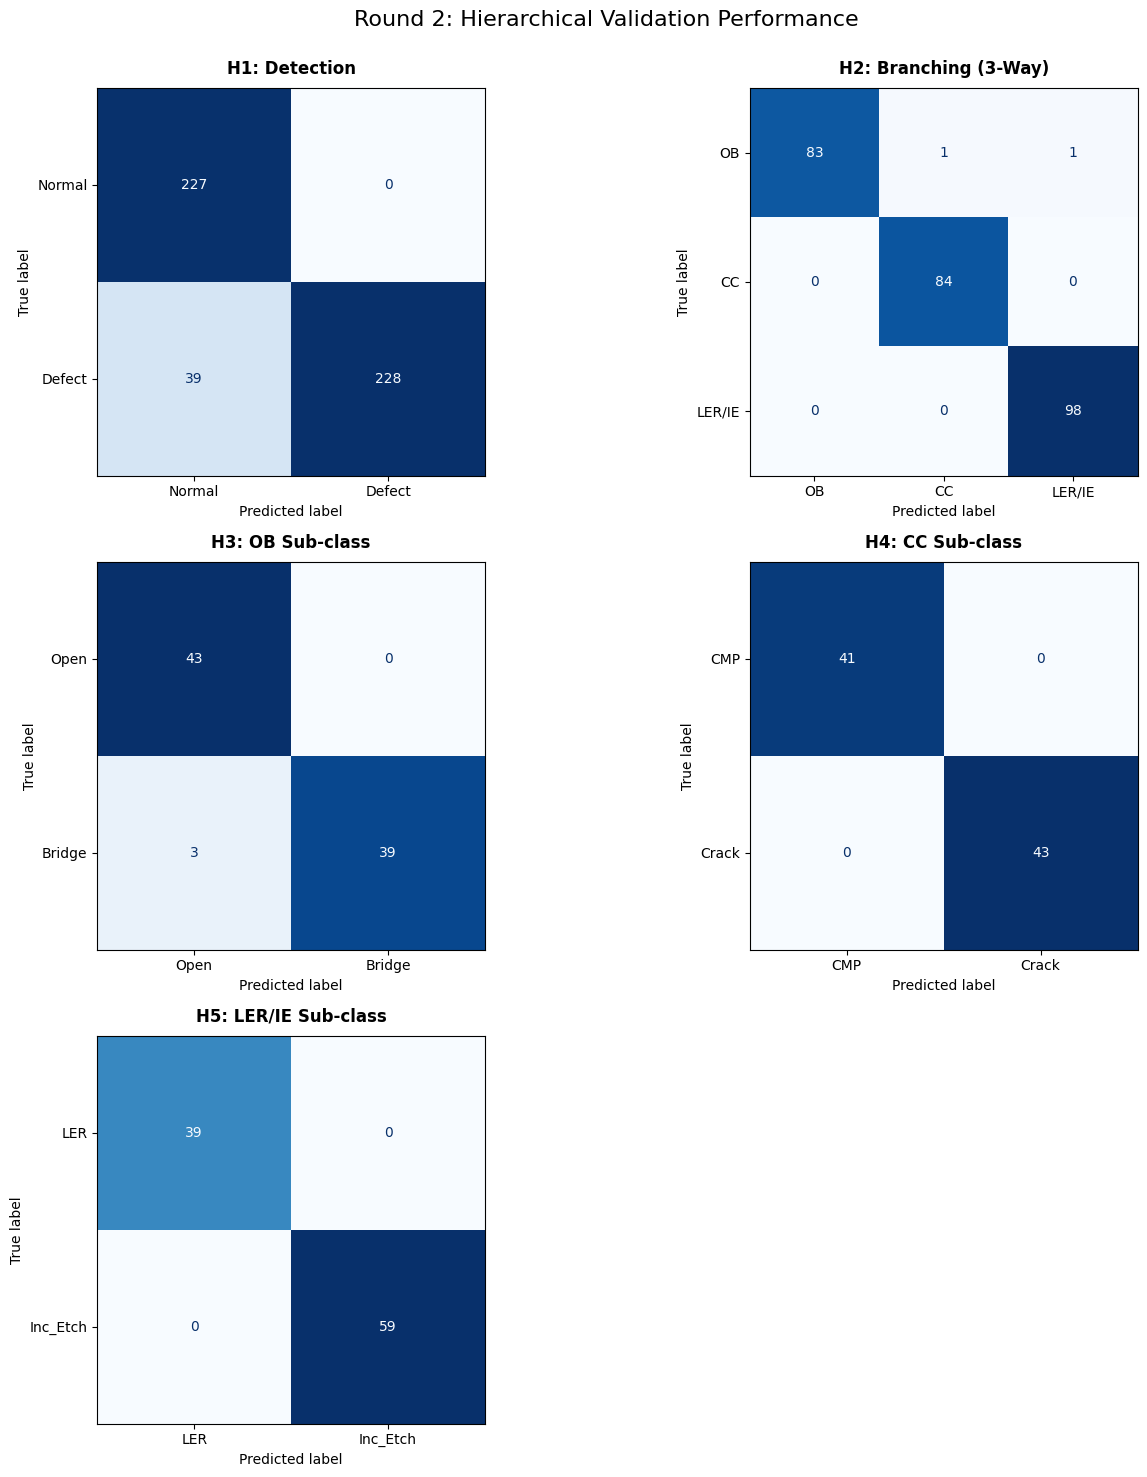

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_validation_confusion_matrices(model, val_loader, device):
    model.eval()

    # Storage for predictions and ground truth
    all_preds = {f'h{i+1}': [] for i in range(5)}
    all_targets = {f'h{i+1}': [] for i in range(5)}

    # Metadata for the plots
    head_metadata = {
        'h1': {'labels': ['Normal', 'Defect'], 'title': 'H1: Detection'},
        'h2': {'labels': ['OB', 'CC', 'LER/IE'], 'title': 'H2: Branching (3-Way)'},
        'h3': {'labels': ['Open', 'Bridge'], 'title': 'H3: OB Sub-class'},
        'h4': {'labels': ['CMP', 'Crack'], 'title': 'H4: CC Sub-class'},
        'h5': {'labels': ['LER', 'Inc_Etch'], 'title': 'H5: LER/IE Sub-class'}
    }

    print("Running inference on validation set...")
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)

            for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                # Mask out -1 (data not belonging to this head's branch)
                mask = labels[:, i] != -1
                if mask.any():
                    # Get predicted class indices
                    preds = torch.argmax(outputs[h_key][mask], dim=1)

                    all_preds[h_key].extend(preds.cpu().numpy())
                    all_targets[h_key].extend(labels[:, i][mask].cpu().numpy())

    # Create the visualization grid
    fig, axes = plt.subplots(3, 2, figsize=(14, 16))
    axes = axes.flatten()

    for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
        meta = head_metadata[h_key]
        cm = confusion_matrix(all_targets[h_key], all_preds[h_key])

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=meta['labels']
        )

        disp.plot(ax=axes[i], cmap='Blues', colorbar=False, values_format='d')
        axes[i].set_title(meta['title'], fontweight='bold', pad=10)
        axes[i].grid(False)

    # Clean up the empty 6th slot
    fig.delaxes(axes[5])
    plt.suptitle("Round 2: Hierarchical Validation Performance", fontsize=16, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# EXECUTE
plot_validation_confusion_matrices(model, val_loader, device)

In [11]:
import torch
import collections

def analyze_h1_struggles(model, loader, device):
    model.eval()
    struggle_counts = collections.defaultdict(int)

    # Map (H2_branch, Sub_head_label) -> Class Name
    class_map = {
        (0, 0): "Open",
        (0, 1): "Bridge",
        (1, 0): "CMP",
        (1, 1): "Crack",
        (2, 0): "LER",
        (2, 1): "Incomplete Etch"
    }

    print(f"Analyzing Head 1 misses on {device}...")

    with torch.no_grad():
        for images, labels in loader:
            # Move images AND labels to the same device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            # h1_preds is now on 'device'
            h1_preds = torch.argmax(outputs['h1'], dim=1)

            # Both tensors are on 'device', so this comparison works
            miss_mask = (h1_preds == 0) & (labels[:, 0] == 1)

            if miss_mask.any():
                missed_labels = labels[miss_mask]

                for lbl in missed_labels:
                    h2_val = lbl[1].item()

                    # Determine leaf class based on Head 2's branch
                    if h2_val == 0: sub_val = lbl[2].item()   # OB branch
                    elif h2_val == 1: sub_val = lbl[3].item() # CC branch
                    elif h2_val == 2: sub_val = lbl[4].item() # LER/IE branch
                    else: continue

                    defect_type = class_map.get((h2_val, sub_val), "Unknown")
                    struggle_counts[defect_type] += 1

    # Final Reporting
    print("\n" + "="*45)
    print(f"{'DEFECT TYPE':<20} | {'MISSES':<10} | {'% OF LEAK'}")
    print("-" * 45)

    total_misses = sum(struggle_counts.values())
    if total_misses == 0:
        print("No defects missed! Head 1 is performing perfectly.")
    else:
        sorted_struggles = sorted(struggle_counts.items(), key=lambda x: x[1], reverse=True)
        for defect, count in sorted_struggles:
            perc = (count / total_misses) * 100
            print(f"{defect:<20} | {count:<10} | {perc:>7.1f}%")
    print("="*45)

# EXECUTE
analyze_h1_struggles(model, val_loader, device)

Analyzing Head 1 misses on cuda...

DEFECT TYPE          | MISSES     | % OF LEAK
---------------------------------------------
Incomplete Etch      | 35         |    89.7%
Bridge               | 3          |     7.7%
Open                 | 1          |     2.6%


In [12]:
import torch.nn.functional as F

def evaluate_with_threshold(model, loader, device, threshold=0.5):
    model.eval()
    struggle_counts = collections.defaultdict(int)
    total_found = 0
    total_missed = 0

    print(f"Testing Threshold: {threshold}")
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Use Softmax to get probabilities instead of raw logits
            probs = F.softmax(outputs['h1'], dim=1)
            # Class 1 is 'Defect'. If prob > threshold, mark as Defect.
            custom_preds = (probs[:, 1] > threshold).long()

            # Find Misses: Pred=Normal(0), Truth=Defect(1)
            miss_mask = (custom_preds == 0) & (labels[:, 0] == 1)

            if miss_mask.any():
                total_missed += miss_mask.sum().item()
                # (Logic to identify which classes were missed, same as before...)
                # ... (omitted for brevity)

    print(f"Total Defects Missed at {threshold}: {total_missed}")
    return total_missed

# Test a more 'paranoid' threshold
new_misses = evaluate_with_threshold(model, val_loader, device, threshold=0.3)

Testing Threshold: 0.3
Total Defects Missed at 0.3: 33


Testing Threshold: 0.5
Total Defects Missed at 0.5: 39
Testing Threshold: 0.4
Total Defects Missed at 0.4: 35
Testing Threshold: 0.3
Total Defects Missed at 0.3: 33
Testing Threshold: 0.2
Total Defects Missed at 0.2: 32
Testing Threshold: 0.1
Total Defects Missed at 0.1: 25
Testing Threshold: 0.05
Total Defects Missed at 0.05: 19


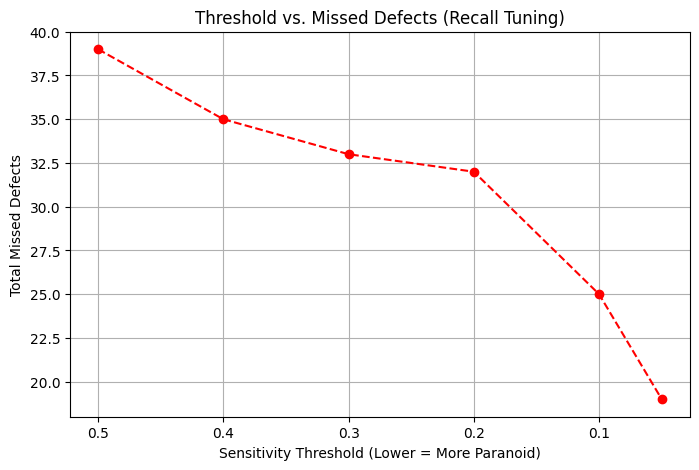

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def run_sensitivity_sweep(model, loader, device):
    thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
    results = []

    for t in thresholds:
        missed = evaluate_with_threshold(model, loader, device, threshold=t)
        results.append({"Threshold": t, "Misses": missed})

    df = pd.DataFrame(results)

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.plot(df['Threshold'], df['Misses'], marker='o', color='red', linestyle='--')
    plt.gca().invert_xaxis() # High threshold to Low threshold
    plt.title("Threshold vs. Missed Defects (Recall Tuning)")
    plt.xlabel("Sensitivity Threshold (Lower = More Paranoid)")
    plt.ylabel("Total Missed Defects")
    plt.grid(True)
    plt.show()

    return df

# Run the sweep
sweep_results = run_sensitivity_sweep(model, val_loader, device)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.ao.quantization as quantization
from torchvision import models
from sklearn.metrics import accuracy_score
import numpy as np

# --- 1. ARCHITECTURE DEFINITION ---

class DeepResHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DeepResHead, self).__init__()
        # Branch 1: Deep Non-linear path
        self.fc1 = nn.Linear(in_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.swish = nn.Hardswish()
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        # Branch 2: Skip connection (projection to match 128 dimensions)
        self.skip = nn.Linear(in_dim, 128)

        # Final classification
        self.fc3 = nn.Linear(128, out_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        residual = self.skip(x)
        out = self.swish(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))

        # Merge residual with deep features
        out += residual
        out = self.swish(out)
        out = self.dropout(out)
        return self.fc3(out)

class SEMHierarchicalNetV3_QAT(nn.Module):
    def __init__(self):
        super(SEMHierarchicalNetV3_QAT, self).__init__()
        self.quant = quantization.QuantStub()
        self.dequant = quantization.DeQuantStub()

        # Backbone remains consistent for fair comparison
        base = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        old_conv = base.features[0][0]
        base.features[0][0] = nn.Conv2d(1, old_conv.out_channels,
                                        kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            base.features[0][0].weight[:] = old_conv.weight.sum(dim=1, keepdim=True)

        self.backbone = base.features
        self.avgpool = base.avgpool
        feat_dim = 576

        # Head 1 upgraded to Residual architecture
        self.head1 = DeepResHead(feat_dim, 2)

        # Heads 2-5 remain lightweight
        self.head2 = self._make_head(feat_dim, 3)
        self.head3 = self._make_head(feat_dim, 2)
        self.head4 = self._make_head(feat_dim, 2)
        self.head5 = self._make_head(feat_dim, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(nn.Linear(in_dim, 128), nn.Hardswish(), nn.Linear(128, out_dim))

    def forward(self, x):
        x = self.quant(x)
        x = self.backbone(x)
        x = self.avgpool(x)
        feat = torch.flatten(x, 1)
        feat_fp = self.dequant(feat)

        return {
            "h1": self.head1(feat_fp),
            "h2": self.head2(feat_fp),
            "h3": self.head3(feat_fp),
            "h4": self.head4(feat_fp),
            "h5": self.head5(feat_fp)
        }

# --- 2. INITIALIZATION ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = SEMHierarchicalNetV3_QAT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0003) # Slightly lower LR for deeper head stability

# --- 3. TRAINING FUNCTION FOR MODEL2 ---

def train_model2(model, train_loader, val_loader, epochs=20):
    print(f"Starting Training for Model 2 (DeepResHead) on {device}...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer2.zero_grad()
            outputs = model(images)

            loss = 0
            for i, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, i] != -1
                if mask.any():
                    loss += criterion(outputs[h][mask], labels[:, i][mask])

            loss.backward()
            optimizer2.step()
            train_loss += loss.item()

        # Validation with Head-wise Accuracy
        model.eval()
        h1_accs, h5_accs = [], [] # Tracking our "problem" and "new" class
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                out = model(images)

                # H1 Check
                h1_mask = labels[:, 0] != -1
                h1_preds = torch.argmax(out['h1'][h1_mask], dim=1)
                h1_accs.append(accuracy_score(labels[:, 0][h1_mask].cpu(), h1_preds.cpu()))

                # H5 (LER/Etch) Check
                h5_mask = labels[:, 4] != -1
                if h5_mask.any():
                    h5_preds = torch.argmax(out['h5'][h5_mask], dim=1)
                    h5_accs.append(accuracy_score(labels[:, 4][h5_mask].cpu(), h5_preds.cpu()))

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss/len(train_loader):.4f} | Val Acc H1: {np.mean(h1_accs):.4f} | Val Acc H5: {np.mean(h5_accs):.4f}")

# EXECUTE
train_model2(model2, train_loader, val_loader)

Starting Training for Model 2 (DeepResHead) on cuda...
Epoch [1/20] Loss: 1.7363 | Val Acc H1: 0.8301 | Val Acc H5: 0.9767
Epoch [2/20] Loss: 0.6508 | Val Acc H1: 0.8436 | Val Acc H5: 0.9767
Epoch [3/20] Loss: 0.3757 | Val Acc H1: 0.8537 | Val Acc H5: 0.9767
Epoch [4/20] Loss: 0.2760 | Val Acc H1: 0.9067 | Val Acc H5: 0.9767
Epoch [5/20] Loss: 0.2545 | Val Acc H1: 0.9050 | Val Acc H5: 0.9833
Epoch [6/20] Loss: 0.2031 | Val Acc H1: 0.9050 | Val Acc H5: 1.0000
Epoch [7/20] Loss: 0.2502 | Val Acc H1: 0.9130 | Val Acc H5: 1.0000
Epoch [8/20] Loss: 0.1643 | Val Acc H1: 0.9352 | Val Acc H5: 1.0000
Epoch [9/20] Loss: 0.1829 | Val Acc H1: 0.9110 | Val Acc H5: 0.9944
Epoch [10/20] Loss: 0.1494 | Val Acc H1: 0.9130 | Val Acc H5: 1.0000
Epoch [11/20] Loss: 0.1489 | Val Acc H1: 0.9291 | Val Acc H5: 1.0000
Epoch [12/20] Loss: 0.1458 | Val Acc H1: 0.9171 | Val Acc H5: 1.0000
Epoch [13/20] Loss: 0.1732 | Val Acc H1: 0.9268 | Val Acc H5: 1.0000
Epoch [14/20] Loss: 0.1349 | Val Acc H1: 0.9309 | Val Acc

Calculating full metrics for Model 2 on cuda...

HEAD       | RECALL     | F1-SCORE   | SAMPLES
------------------------------------------------------------
h1         | 0.9058     | 0.9027     | 494
h2         | 0.9785     | 0.9777     | 267
h3         | 0.9286     | 0.9289     | 85
h4         | 1.0000     | 1.0000     | 84
h5         | 1.0000     | 1.0000     | 98


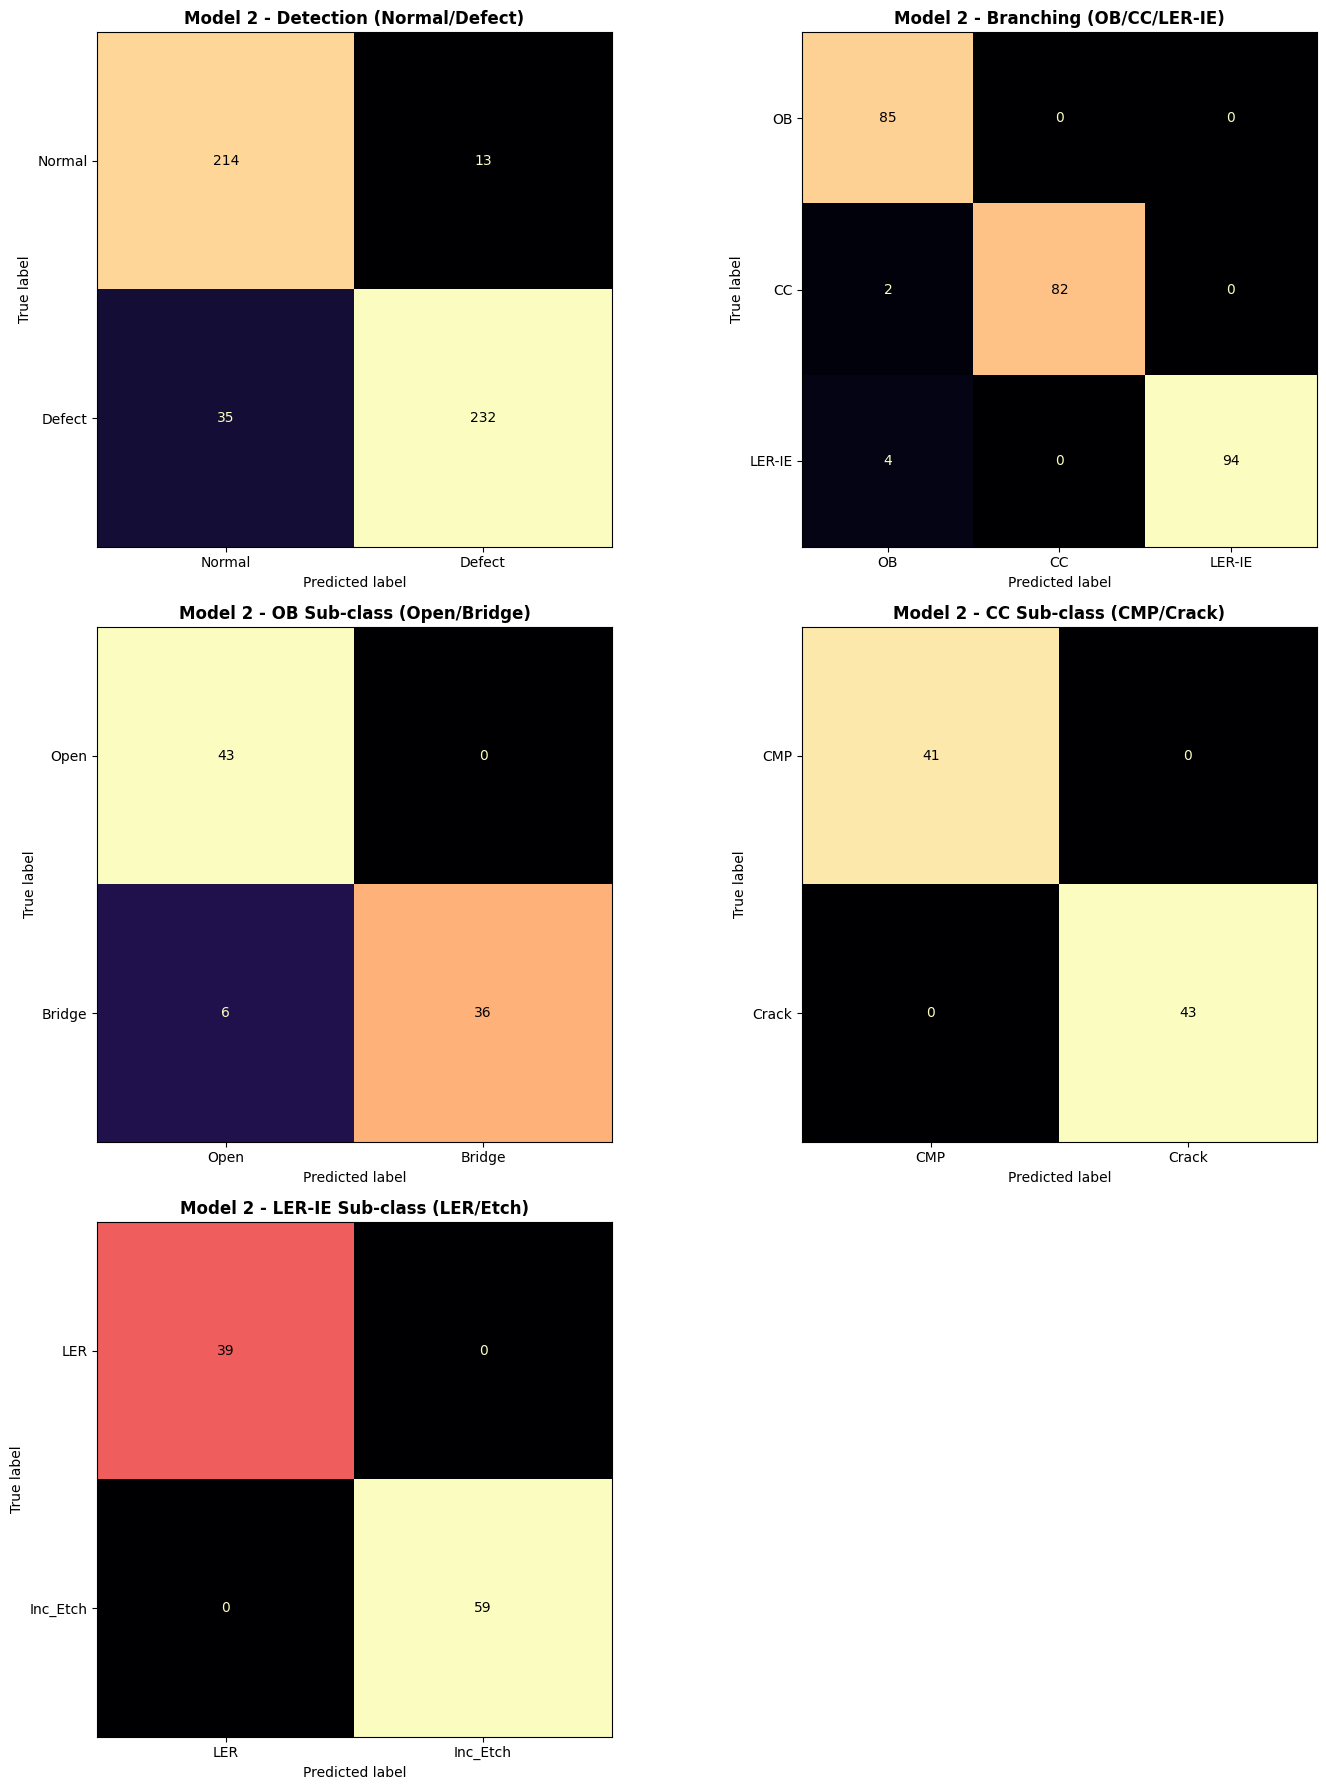

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model2_full_metrics(model, loader, device):
    model.eval()

    # Storage for predictions and targets per head
    all_preds = {f'h{i+1}': [] for i in range(5)}
    all_targets = {f'h{i+1}': [] for i in range(5)}

    # Metadata for reporting
    head_names = {
        'h1': 'Detection (Normal/Defect)',
        'h2': 'Branching (OB/CC/LER-IE)',
        'h3': 'OB Sub-class (Open/Bridge)',
        'h4': 'CC Sub-class (CMP/Crack)',
        'h5': 'LER-IE Sub-class (LER/Etch)'
    }

    print(f"Calculating full metrics for Model 2 on {device}...")

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, i] != -1
                if mask.any():
                    preds = torch.argmax(outputs[h_key][mask], dim=1)
                    all_preds[h_key].extend(preds.cpu().numpy())
                    all_targets[h_key].extend(labels[:, i][mask].cpu().numpy())

    # --- 1. DISPLAY NUMERICAL METRICS ---
    print("\n" + "="*60)
    print(f"{'HEAD':<10} | {'RECALL':<10} | {'F1-SCORE':<10} | {'SAMPLES'}")
    print("-" * 60)

    for h in ['h1', 'h2', 'h3', 'h4', 'h5']:
        y_true = all_targets[h]
        y_pred = all_preds[h]

        if len(y_true) > 0:
            # Using 'macro' average to give equal weight to small defect classes
            rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
            print(f"{h:<10} | {rec:<10.4f} | {f1:<10.4f} | {len(y_true)}")
    print("="*60)

    # --- 2. PLOT CONFUSION MATRICES ---
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()

    class_labels = {
        'h1': ['Normal', 'Defect'],
        'h2': ['OB', 'CC', 'LER-IE'],
        'h3': ['Open', 'Bridge'],
        'h4': ['CMP', 'Crack'],
        'h5': ['LER', 'Inc_Etch']
    }

    for i, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
        cm = confusion_matrix(all_targets[h], all_preds[h])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels[h])
        disp.plot(ax=axes[i], cmap='magma', colorbar=False)
        axes[i].set_title(f"Model 2 - {head_names[h]}", fontweight='bold')
        axes[i].grid(False)

    fig.delaxes(axes[5]) # Remove unused plot
    plt.tight_layout()
    plt.show()

# EXECUTE
evaluate_model2_full_metrics(model2, val_loader, device)

In [16]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score

def refined_train_model2(model, train_loader, val_loader, epochs=10):
    # 1. Setup Head Weights (Focusing 3x more on H1)
    head_weights = {'h1': 3.0, 'h2': 1.0, 'h3': 1.0, 'h4': 0.5, 'h5': 0.5}

    # 2. Re-initialize Optimizer for refinement
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Ensure criterion is accessible (usually nn.CrossEntropyLoss)
    criterion = torch.nn.CrossEntropyLoss()

    print(f"Starting Refinement for Model 2 (Target: H1 Recovery)")
    print(f"Weights: {head_weights}")
    print("-" * 30)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            total_loss = 0
            for i, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, i] != -1
                if mask.any():
                    # Weighted Loss Application
                    loss_component = criterion(outputs[h][mask], labels[:, i][mask])
                    total_loss += head_weights[h] * loss_component

            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        # --- Real-time H1 Validation ---
        model.eval()
        h1_preds, h1_true = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                out = model(images)
                # Mask for H1 (should be everything in val)
                mask = labels[:, 0] != -1
                preds = torch.argmax(out['h1'][mask], dim=1)
                h1_preds.extend(preds.cpu().numpy())
                h1_true.extend(labels[:, 0][mask].cpu().numpy())

        current_h1_acc = accuracy_score(h1_true, h1_preds)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss/len(train_loader):.4f} | Val H1 Acc: {current_h1_acc:.4f}")

# EXECUTE
refined_train_model2(model2, train_loader, val_loader, epochs=10)

Starting Refinement for Model 2 (Target: H1 Recovery)
Weights: {'h1': 3.0, 'h2': 1.0, 'h3': 1.0, 'h4': 0.5, 'h5': 0.5}
------------------------------
Epoch [1/10] | Loss: 0.3212 | Val H1 Acc: 0.9413
Epoch [2/10] | Loss: 0.2292 | Val H1 Acc: 0.9352
Epoch [3/10] | Loss: 0.2470 | Val H1 Acc: 0.9372
Epoch [4/10] | Loss: 0.2084 | Val H1 Acc: 0.9433
Epoch [5/10] | Loss: 0.2097 | Val H1 Acc: 0.9474
Epoch [6/10] | Loss: 0.2530 | Val H1 Acc: 0.9453
Epoch [7/10] | Loss: 0.2181 | Val H1 Acc: 0.9352
Epoch [8/10] | Loss: 0.1980 | Val H1 Acc: 0.9474
Epoch [9/10] | Loss: 0.2046 | Val H1 Acc: 0.9494
Epoch [10/10] | Loss: 0.1763 | Val H1 Acc: 0.9433


--- Comprehensive Hierarchical Evaluation on cuda ---

H1: Detection (Primary) Report:
              precision    recall  f1-score   support

      Normal     0.8902    1.0000    0.9419       227
      Defect     1.0000    0.8951    0.9447       267

    accuracy                         0.9433       494
   macro avg     0.9451    0.9476    0.9433       494
weighted avg     0.9495    0.9433    0.9434       494


H2: Branching (3-Way) Report:
              precision    recall  f1-score   support

          OB     0.9659    1.0000    0.9827        85
          CC     1.0000    1.0000    1.0000        84
      LER-IE     1.0000    0.9694    0.9845        98

    accuracy                         0.9888       267
   macro avg     0.9886    0.9898    0.9890       267
weighted avg     0.9891    0.9888    0.9888       267


H3: OB Sub-classes Report:
              precision    recall  f1-score   support

        Open     0.9556    1.0000    0.9773        43
      Bridge     1.0000    0.9524    

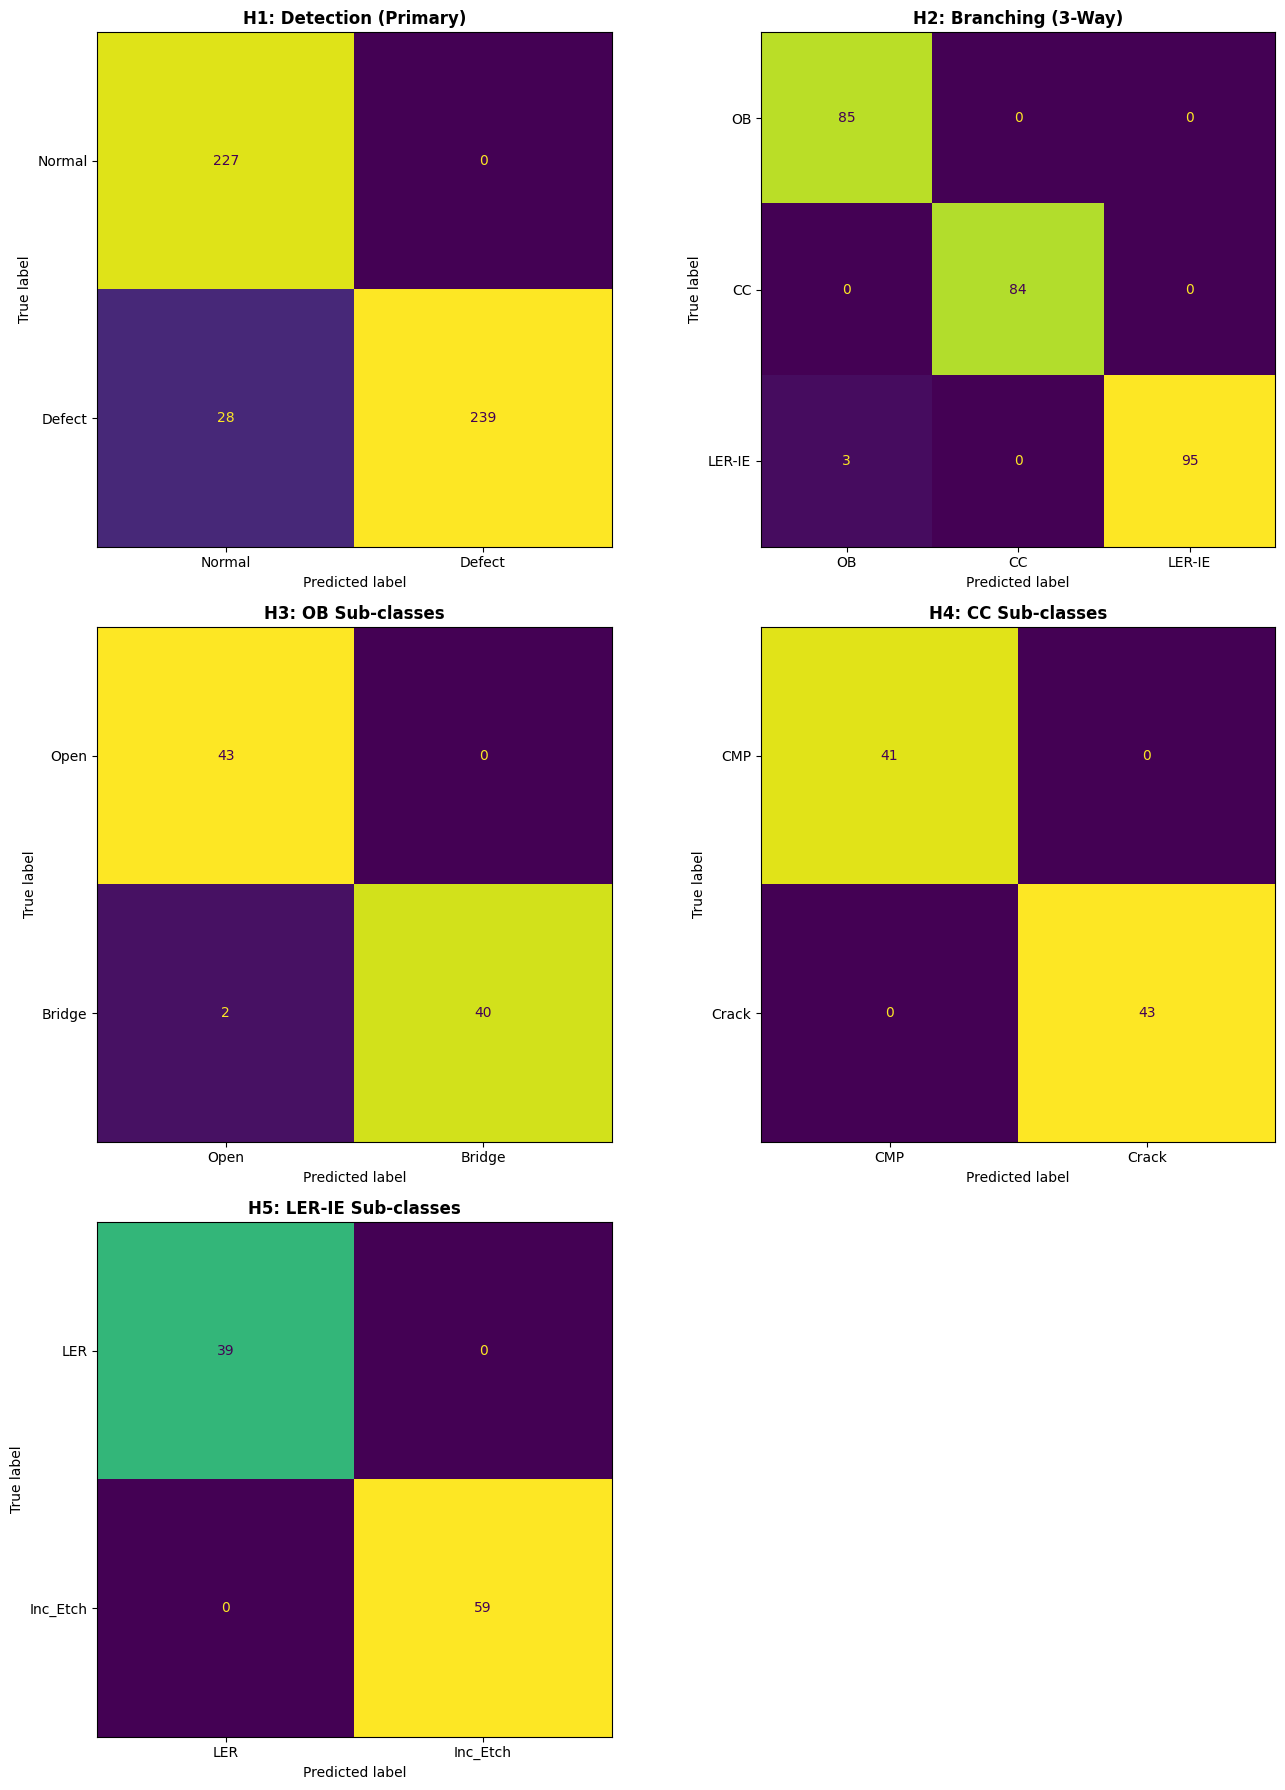

In [17]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def evaluate_refined_hierarchical_model(model, loader, device):
    model.eval()

    # Storage for predictions and ground truth per head
    results = {f'h{i+1}': {'preds': [], 'true': []} for i in range(5)}

    # Human-readable labels for the hierarchy
    head_metadata = {
        'h1': {'labels': ['Normal', 'Defect'], 'title': 'H1: Detection (Primary)'},
        'h2': {'labels': ['OB', 'CC', 'LER-IE'], 'title': 'H2: Branching (3-Way)'},
        'h3': {'labels': ['Open', 'Bridge'], 'title': 'H3: OB Sub-classes'},
        'h4': {'labels': ['CMP', 'Crack'], 'title': 'H4: CC Sub-classes'},
        'h5': {'labels': ['LER', 'Inc_Etch'], 'title': 'H5: LER-IE Sub-classes'}
    }

    print(f"--- Comprehensive Hierarchical Evaluation on {device} ---")

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                # Filter out -1 mask values
                mask = labels[:, i] != -1
                if mask.any():
                    preds = torch.argmax(outputs[h_key][mask], dim=1)
                    results[h_key]['preds'].extend(preds.cpu().numpy())
                    results[h_key]['true'].extend(labels[:, i][mask].cpu().numpy())

    # 1. Output Classification Reports for all heads
    for h_key in ['h1', 'h2', 'h3', 'h4', 'h5']:
        if len(results[h_key]['true']) > 0:
            print(f"\n{head_metadata[h_key]['title']} Report:")
            print(classification_report(
                results[h_key]['true'],
                results[h_key]['preds'],
                target_names=head_metadata[h_key]['labels'],
                digits=4
            ))

    # 2. Generate the Confusion Matrix Grid
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    axes = axes.flatten()

    for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
        cm = confusion_matrix(results[h_key]['true'], results[h_key]['preds'])
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=head_metadata[h_key]['labels']
        )
        disp.plot(ax=axes[i], cmap='viridis', colorbar=False, values_format='d')
        axes[i].set_title(head_metadata[h_key]['title'], fontweight='bold')
        axes[i].grid(False)

    # Clean up the layout
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

# EXECUTE
evaluate_refined_hierarchical_model(model2, val_loader, device)

In [18]:
import torch

def display_missed_defect_filenames(model, val_subset, device, head='h1'):
    model.eval()
    # Create a local loader for the subset to keep indices aligned
    loader = torch.utils.data.DataLoader(val_subset, batch_size=1, shuffle=False)

    # Extract original indices from the subset
    val_indices = val_subset.indices
    missed_files = []

    print(f"--- Searching for {head.upper()} False Negatives (Outlier Candidates) ---")

    with torch.no_grad():
        for i, (image, label) in enumerate(loader):
            image = image.to(device)
            output = model(image)

            # Prediction for Head 1
            pred = torch.argmax(output[head], dim=1).item()
            true_label = label[0, 0].item() # H1 is the first column

            # Identification of False Negative: True=Defect(1), Pred=Normal(0)
            if true_label == 1 and pred == 0:
                # Map back to the original dataset's file list
                original_idx = val_indices[i]
                file_path = full_dataset.image_paths[original_idx]
                missed_files.append(file_path)
                print(f"Missed Defect Found: {os.path.basename(file_path)}")

    print(f"\nTotal Outlier Candidates: {len(missed_files)}")
    return missed_files

# EXECUTE
# Ensure 'full_dataset' and 'val_subset' are defined from your previous steps
outlier_paths = display_missed_defect_filenames(model2, val_subset, device)

--- Searching for H1 False Negatives (Outlier Candidates) ---
Missed Defect Found: test_normal_00010.jpg
Missed Defect Found: test_normal_00053.jpg
Missed Defect Found: WhatsApp Image 2026-02-06 at 7.04.09 PM_90.jpeg
Missed Defect Found: test_normal_00001.jpg
Missed Defect Found: test_normal_00125.jpg
Missed Defect Found: test_normal_00005.jpg
Missed Defect Found: test_normal_00153.jpg
Missed Defect Found: test_normal_00149.jpg
Missed Defect Found: test_normal_00041.jpg
Missed Defect Found: test_normal_00186.jpg
Missed Defect Found: test_normal_00113.jpg
Missed Defect Found: test_normal_00098.jpg
Missed Defect Found: test_normal_00063.jpg
Missed Defect Found: WhatsApp Image 2026-02-06 at 7.04.09 PM.jpeg
Missed Defect Found: test_normal_00118.jpg
Missed Defect Found: WhatsApp Image 2026-02-06 at 7.42.14 PM.jpeg
Missed Defect Found: test_normal_00081.jpg
Missed Defect Found: test_normal_00009.jpg
Missed Defect Found: test_normal_00049.jpg
Missed Defect Found: test_normal_00042.jpg
Missed